In [8]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings as w 
w.filterwarnings('ignore')
sns.set(style='whitegrid')  


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC, SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier , AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier

In [9]:
class INGESTION:
    def __init__(self):
        pass
    def ingestion(self, df_path: pd.DataFrame):
        df = pd.read_csv(df_path, sep=';')
        df['y']= df['y'].map({'yes': 1, 'no': 0})
        
        train, test = train_test_split(df, random_state=42, test_size=0.2, stratify=df['y'])

        return train, test


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC
import numpy as np
import pandas as pd

class TRANSFORMATION:
    def __init__(self):
        pass

    def manual_feature_engineering(self, train, test):

        oe_education = OrdinalEncoder(categories=[['secondary', 'primary', 'tertiary', 'unknown']])
        train['education'] = oe_education.fit_transform(train[['education']])
        test['education'] = oe_education.transform(test[['education']])

        oe_job = OrdinalEncoder(categories=[[
            'services', 'blue-collar', 'technician', 'admin.', 'housemaid',
            'entrepreneur', 'management', 'unemployed', 'self-employed',
            'student', 'retired', 'unknown'
        ]])
        train['job'] = oe_job.fit_transform(train[['job']])
        test['job'] = oe_job.transform(test[['job']])

        for col in ['default', 'loan', 'housing']:
            train[col] = train[col].map({'yes': 1, 'no': 0})
            test[col] = test[col].map({'yes': 1, 'no': 0})


        month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                     'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
        train['month'] = train['month'].map(month_map)
        test['month'] = test['month'].map(month_map)

        for df in [train, test]:
            df['cyclic_sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
            df['cyclic_cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
            df['cyclic_sin_day'] = np.sin(2 * np.pi * df['day'] / 31)
            df['cyclic_cos_day'] = np.cos(2 * np.pi * df['day'] / 31)
            df['dept'] = df['balance'].apply(lambda x: 1 if x >= 0 else 0)
            df.drop(columns=['month', 'day'], inplace=True)

        return train, test

    def preprocessing(self, train_data):
        num_cols = train_data.select_dtypes(include=['number']).columns.tolist()
        cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

        num_pipe = Pipeline([
            ('impute', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        cat_pipe = Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ])

        preprocessing = ColumnTransformer([
            ('num', num_pipe, num_cols),
            ('cat', cat_pipe, cat_cols)
        ])

        return preprocessing

    def transformation(self, train_df, test_df):
        train_df, test_df = self.manual_feature_engineering(train_df, test_df)

        train_X = train_df.drop('y', axis=1)
        train_y = train_df['y']

        test_X = test_df.drop('y', axis=1)
        test_y = test_df['y']

        cat_col = train_X.select_dtypes(include=['object']).columns.tolist()
        cat_idx = [train_X.columns.get_loc(col) for col in cat_col]

        smotenc = SMOTENC(categorical_features=cat_idx,
                          sampling_strategy='minority',
                          random_state=42)

        X_resampled, y_resampled = smotenc.fit_resample(train_X, train_y)

        preprocessor_obj = self.preprocessing(train_X)

        X_train_scaled = preprocessor_obj.fit_transform(X_resampled)
        X_test_scaled = preprocessor_obj.transform(test_X)

        train_arr = np.c_[X_train_scaled, y_resampled]
        test_arr = np.c_[X_test_scaled, test_y]

        return train_arr, test_arr


In [26]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

class MODEL_TRAINER:
    def __init__(self, resampling_strategy='smote'):
        self.resampling_strategy = resampling_strategy 

    def trainer(self, train_arr, test_arr):
        X_train, y_train = train_arr[:, :-1], train_arr[:, -1]
        X_test, y_test = test_arr[:, :-1], test_arr[:, -1]

        xgb = XGBClassifier(
            scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
            n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'
        )
        ada = AdaBoostClassifier(n_estimators=100, random_state=42)

        estimators = [
            ('xgb', xgb),
            ('ada', ada)
        ]

        final_estimator = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

        if self.resampling_strategy == 'smote':
            resampler = SMOTE(random_state=42)
            pipeline = ImbPipeline([
                ('resample', resampler),
                ('stack', StackingClassifier(
                    estimators=estimators,
                    final_estimator=final_estimator,
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    stack_method='predict_proba'
                ))
            ])
        else:
            pipeline = StackingClassifier(
                estimators=estimators,
                final_estimator=final_estimator,
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                stack_method='predict_proba'
            )

        # Train
        model = pipeline.fit(X_train, y_train)
        return model, X_test, y_test


In [13]:
class EVALUATE:
    def __init__(self):
        pass
    def threshold_calculator(self, model, X_test, y_test):
        y_proba = model.predict_proba(X_test)[:,1]
        thresholds = np.linspace(0.05,0.95,21)
        results=[]
        print(model)
        for threshold in thresholds:
            y_pred = (y_proba>= threshold).astype(int)
            recall = recall_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
            precision = precision_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
            f1 = f1_score(y_test, y_pred)
            roc= roc_auc_score(y_test, y_pred)
            results.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc
            })
        result_df= pd.DataFrame(results)
        print(result_df)
        return pd.DataFrame(result_df)
    
    def decor(self, result_df):
        best_row = result_df.iloc[result_df['f1'].idxmax()]
        print(f'Best threshold: {best_row['threshold']}')
        print(f'Best Precision: {best_row['precision']}')
        print(f'Best recall: {best_row['recall']}')
        print(f'Best f1: {best_row['f1']}')
        return None
    
    def plotting_the_curve(self, result_df):
        best_row = result_df.iloc[result_df['f1'].idxmax()]
        plt.figure(figsize=(10, 6))
        plt.plot(result_df['threshold'], result_df['precision'], label='Precision')
        plt.plot(result_df['threshold'], result_df['recall'], label='Recall')
        plt.plot(result_df['threshold'], result_df['f1'], label='F1 Score', linestyle='--')
        plt.axvline(best_row['threshold'], color='red', linestyle=':', label=f'Optimal (F1)')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Precision-Recall Tradeoff')
        plt.legend()
        plt.grid()
        plt.show()



Pipeline(steps=[('resample', SMOTE(random_state=42)),
                ('stack',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                    estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
              

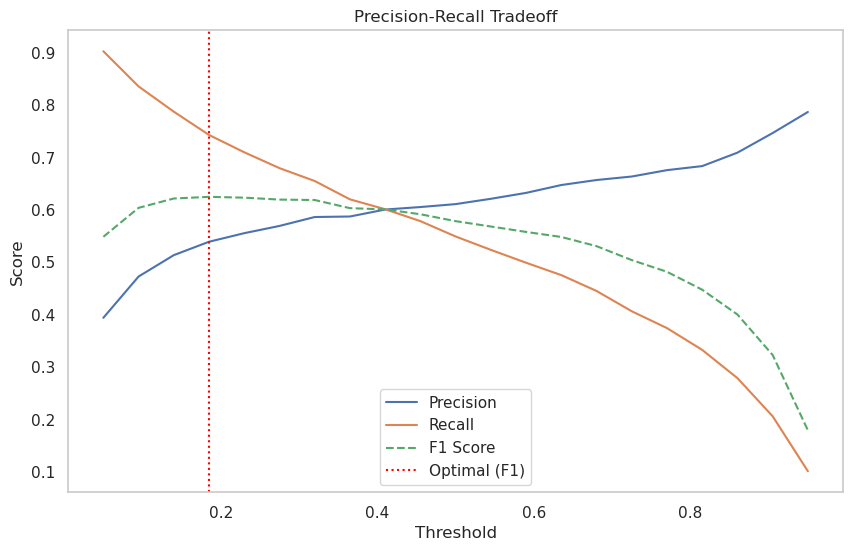

In [27]:
data_ingestion = INGESTION()
path = '../artifacts/raw.csv'
train, test = data_ingestion.ingestion(path)

data_transformation = TRANSFORMATION()
train_arr, test_arr = data_transformation.transformation(train, test)

model_trainer = MODEL_TRAINER()
model, X_test, y_test = model_trainer.trainer(train_arr, test_arr)

evaluate = EVALUATE()
resultant_df =  evaluate.threshold_calculator(model,X_test, y_test)

evaluated_values = evaluate.decor(resultant_df)

plotting = evaluate.plotting_the_curve(resultant_df)